In [1]:
from collections import namedtuple
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import morknn.matplotlib_themes
from morknn.layers import Layer
import morknn.activators
# from morknn.datasets import mnist_dataset

%config InlineBackend.figure_formats = ['svg']

In [16]:
def mnist_dataset(split_factor=0.05, verbose=False, transpose_x=False):
    data_df = pd.read_csv(f'./datasets/mnist/train.csv')
    data_x = data_df[data_df.columns[1:]].to_numpy() / 255
    data_x = data_x.astype(np.float32)
    data_y = data_df['label'].to_numpy()
    data_y = data_y.astype(np.int32)
    split_index = int(data_y.shape[0] * split_factor)
    train_x = data_x[split_index:, :]
    val_x = data_x[:split_index, :]
    train_y = data_y[split_index:]
    val_y = data_y[:split_index]
    if verbose:
        print(f'   train_x shape = {train_x.shape}')
        print(f'   train_y shape = {train_y.shape}')
        print(f'     val_x shape = {val_x.shape}')
        print(f'     val_y shape = {val_y.shape}')
    return train_x, train_y, val_x, val_y

def one_hot(data_y):
    n_labels = data_y.shape[0]
    n_options = int(data_y.max())
    one_hoty = np.zeros((n_labels, n_options + 1))
    one_hoty[np.arange(n_labels), data_y] = 1
    return one_hoty.reshape(*one_hoty.shape)

def uno_plot(data_x):
    fig, ax = plt.subplots(1, figsize=(2, 2))
    ax.imshow(data_x[0].reshape(28, 28))
    plt.axis('off')
    plt.tight_layout()
    
def data_shapes(data_x, data_y):
    data_y_oh = one_hot(data_y)
    print(f'first image is a: {data_y[0]}')
    print(f'in OH form, it\'s: {data_y_oh[0]} --> {np.argmax(data_y_oh[0])}')
    print(f'the image.......:')
    uno_plot(data_x)

   train_x shape = (39900, 784)
   train_y shape = (39900,)
     val_x shape = (2100, 784)
     val_y shape = (2100,)
first image is a: 8
in OH form, it's: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] --> 8
the image.......:


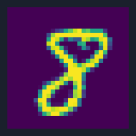

In [17]:
train_x, train_y, val_x, val_y = mnist_dataset(verbose=True, transpose_x=False)
data_shapes(train_x, train_y)

In [83]:
# model parameters
n_options_y = train_y.max() + 1
model_outputs = n_options_y
n_training_images, n_pixels_per_image = train_x.shape

# 1 layer model
model = Layer(
    input_dim=n_pixels_per_image,
    output_dim=model_outputs,
    activation='softmax',
    name='layer_1'
)
print('model shapes:')
print(f' - shape of W = {model.weights.shape}')
print(f' - shape of B = {model.bias.shape}')
print(f' - activation = {model.activation.name}')

model shapes:
 - shape of W = (10, 784)
 - shape of B = (10, 1)
 - activation = softmax


In [90]:
n_images, n_pixels = train_x.shape
batch = 100
learning_rate = 0.005
train_y_oh = one_hot(train_y)

def forward(model, data_x):
    z = np.add(np.matmul(model.weights, data_x.T), model.bias)
    a = model.activation.activation(z)
    return z, a

def predict(batch_x, batch_y):
    z, a = forward(model, batch_x)
    y_hat = np.argmax(a, axis=0)
    y_ = np.argmax(batch_y, axis=1)
    accuracy = (y_hat == y_).mean()
    return accuracy


verbose = True
for epoch in range(5):
    if verbose:
        print(f'epoch: {epoch}')
    for n in range(int(n_images / batch)):
        indices = np.random.permutation(batch)
        batch_x = train_x[n*batch: min(n * batch + batch, n_images)][indices]
        batch_y = train_y_oh[n*batch: min(n * batch + batch, n_images)][indices]

        # FORWARD
        z, a = forward(model, batch_x)

        # BACKWARD
        error = np.subtract(a.T, batch_y)
        delta_w = np.matmul(error.T, batch_x) / batch
        delta_b = np.sum(error.T, axis=1, keepdims=True) / batch

        # LOSS
        loss = -np.mean(batch_y * np.log(a.T))

        # UPDATE WEIGHTS & BIAS
        model.weights = model.weights - learning_rate * delta_w
        
        model.bias = model.bias - learning_rate * delta_b
        if n % 50 == 0 and verbose:
            pred = predict(batch_x, batch_y)
            print(f'  step={n:03d}/{int(n_images / batch)} loss={loss:.5f}, accuracy={pred:.3f}')

epoch: 0
  step=000/399 loss=0.04673, accuracy=0.850
  step=050/399 loss=0.07169, accuracy=0.810
  step=100/399 loss=0.08893, accuracy=0.770
  step=150/399 loss=0.06826, accuracy=0.750
  step=200/399 loss=0.04664, accuracy=0.850
  step=250/399 loss=0.07904, accuracy=0.780
  step=300/399 loss=0.06699, accuracy=0.810
  step=350/399 loss=0.06294, accuracy=0.800
epoch: 1
  step=000/399 loss=0.04649, accuracy=0.850
  step=050/399 loss=0.07059, accuracy=0.810
  step=100/399 loss=0.08790, accuracy=0.790
  step=150/399 loss=0.06712, accuracy=0.760
  step=200/399 loss=0.04567, accuracy=0.850
  step=250/399 loss=0.07807, accuracy=0.780
  step=300/399 loss=0.06608, accuracy=0.810
  step=350/399 loss=0.06189, accuracy=0.810
epoch: 2
  step=000/399 loss=0.04627, accuracy=0.850
  step=050/399 loss=0.06955, accuracy=0.810
  step=100/399 loss=0.08692, accuracy=0.790
  step=150/399 loss=0.06604, accuracy=0.770
  step=200/399 loss=0.04475, accuracy=0.850
  step=250/399 loss=0.07716, accuracy=0.780
  ste

[1 0 1 0 0 0 7 8 5 3]


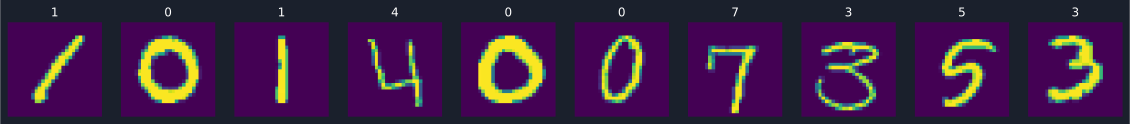

In [116]:
def predict_(batch_x, batch_y):
    z, a = forward(model, batch_x)
    y_hat = np.argmax(a, axis=0)
    y_ = np.argmax(batch_y, axis=1)
    accuracy = (y_hat == y_).mean()
    return accuracy

def forward_(model, data_x):
    z = np.add(np.matmul(model.weights, data_x.T), model.bias)
    a = model.activation.activation(z)
    return z, a


n = 10
z, a = forward_(model, val_x[:n])
print(np.argmax(a, axis=0))

fig, axes = plt.subplots(1, n, figsize=(2 * n, 2.4))
for im, label, ax in zip(val_x[:n], val_y[:n], axes):
    ax.imshow(im.reshape(28, 28))
    ax.axis('off')
    ax.set_title(label)

## Multiply 2 matrices

$$
\large{
\mathbf{C}_{q, p} = \mathbf{A}_{q, n} \cdot \mathbf{B}_{n, p}\,, \qquad \text{where}\,\qquad  c_{i, j} = \sum_{k=0}^{n}a_{i, k}b_{k, j}
}
$$

## the math

$$
\large{\begin{align}
\mathbf{\hat{Y}} &= \mathbf{\sigma}\left\{\mathbf{Z}\right\}\\
\mathbf{\hat{Y}} &= \mathbf{\sigma} \left\{ \mathbf{W} \cdot \mathbf{X} + \mathbf{B}\right\}\\
\end{align}}
$$

the shape of each element is

$$
\large{\begin{align}
    \mathbf{X}_{784, 1}&=\left(
        \begin{matrix}
            x_0 \\ x_1 \\ \vdots \\ x_{783}
        \end{matrix}\right)\\[10pt]
\mathbf{W}_{10, 784}&=\left( 
    \begin{matrix}
        w_{0, 0} & w_{0, 1} & \dots & w_{0, 783} \\
        w_{1, 0} & w_{1, 1} & \dots & w_{1, 783} \\ 
        \vdots   & \vdots   & \ddots& \vdots     \\ 
        w_{9, 0} & w_{9, 1} & \dots & w_{9, 783} \\ 
    \end{matrix}\right)\\[10pt]
    \mathbf{B}_{10, 1}&=\left(
        \begin{matrix}
            b_0 \\ b_1 \\ \vdots \\ b_{9}
        \end{matrix}\right)
\end{align}}
$$

Going from $\mathbf{X}$ (_inout image data_) to $\mathbf{\hat{Y}}$ (_output label data_), do the following _forward pass_. 

$$
\large{\begin{align}
    \mathbf{\hat{Y}}&=\sigma\left\{ \mathbf{Z} \right\}\\
    \mathbf{\hat{Y}}&=\sigma\left\{ \mathbf{W} \cdot \mathbf{X} + \mathbf{B} \right\}\\
    \mathbf{\hat{Y}}_{10, 1}&=\sigma \bigg\{\, \underbrace{\mathbf{W}_{10, 784} \cdot \mathbf{X}_{784, 1}}_{\mathbf{R}_{10, 1}} + \mathbf{B}_{10, 1} \bigg\}\\
    \mathbf{\hat{Y}}_{10, 1}&=\sigma\left\{ \mathbf{R}_{10, 1} + \mathbf{B}_{10, 1} \right\}\\
    \mathbf{\hat{Y}}_{10, 1}&=\sigma\left\{ \mathbf{Z}_{10, 1} \right\}\\
    \mathbf{\hat{Y}}_{10, 1}&=\mathbf{A}_{10, 1}
\end{align}}
$$

## Loss function

The loss function (see [link](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html))

$$
\large{\begin{align}
\mathcal{L}=-\sum_{i=0}^{c}y_i\ln\left( a_i \right)
\end{align}}
$$

## back-propagation

$$
\large{\begin{align}
\frac{\mathcal{L}}{d\mathbf{W}^l}&=\left( \mathbf{A}^l - \mathbf{\hat{Y}}^l \right) \mathbf{A}^{l-1}\\[4pt]
\frac{\mathcal{L}}{d\mathbf{W}^{l-1}}&=\left( \mathbf{A}^l - \mathbf{\hat{Y}}^l \right) \left( \mathbf{A}^{l-1} - \mathbf{\hat{Y}}^{l-1} \right) \mathbf{A}^{l-2}
\end{align}}
$$

## Define the model in code

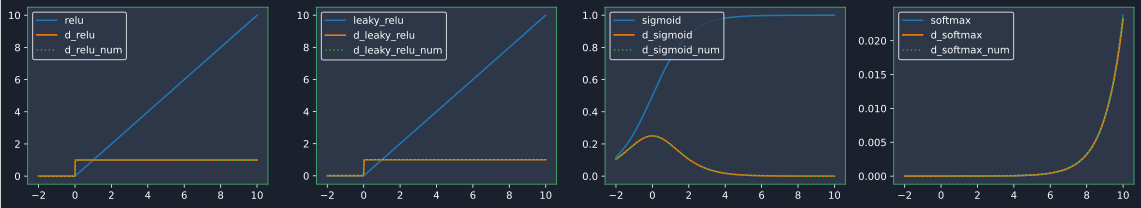

In [7]:
from morknn.activators import Activator

actnames = ['relu', 'leaky_relu', 'sigmoid', 'softmax']
fig, axes = plt.subplots(1, len(actnames), figsize=(16, 3))

for ax, actname in zip(axes, actnames):
    z = np.linspace(-2, 10, 500)
    act = Activator(name=actname)
    y = act._act()(z)
    dy = act._d_act()(z)
    dy_num = act.d_general(z)
    ax.plot(z, y, label=actname)
    ax.plot(z, dy, label=f'd_{actname}')
    ax.plot(z, dy_num, ls=':', label=f'd_{actname}_num')
    ax.legend(loc=2)
plt.tight_layout()